# Aquisição de dados

In [2]:
# https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data
!curl -L -o ./lgg-mri-segmentation.zip https://www.kaggle.com/api/v1/datasets/download/mateuszbuda/lgg-mri-segmentation

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  713M  100  713M    0     0  28.4M      0  0:00:25  0:00:25 --:--:-- 31.6M


In [3]:
!unzip -q lgg-mri-segmentation.zip

# UNet++

In [9]:
!pip install -qU segmentation-models-pytorch

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from torchvision.transforms import ToTensor, Lambda
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class LGGSegmentationDataset(Dataset):
    ''' Classe que representa o dataset apresentado.

    Para mais detalhes sobre Datasets e DataLoaders do Pytorch veja:
    https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html '''

    def __init__(self, dataset_root_dir: Path, transform=None):
        self.dataset_root_dir = dataset_root_dir
        self.transform = transform
        self.mask_paths = list(self.dataset_root_dir.glob('*/*_mask.tif'))
        self.image_paths = [(path.parent / path.name.replace('_mask', '')) for path in self.mask_paths]

    def __len__(self):
        assert len(self.mask_paths) == len(self.image_paths)
        return len(self.mask_paths)

    def __getitem__(self, idx):
        image = cv2.imread(str(self.image_paths[idx]))
        mask = cv2.imread(str(self.mask_paths[idx]), cv2.IMREAD_GRAYSCALE)  # lendo em tons de cinza (padrão-> BGR)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        if self.transform:  # Aplicar algum conjunto de transformações, se for necessário
            image = self.transform(image)


        return image, mask

In [3]:
lgg_dataset = LGGSegmentationDataset(dataset_root_dir=Path('./kaggle_3m'), transform=ToTensor())

# Divisão em conjunto de treino e conjunto de teste
train_dataset, test_dataset = random_split(lgg_dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Shape:  torch.Size([32, 3, 256, 256])


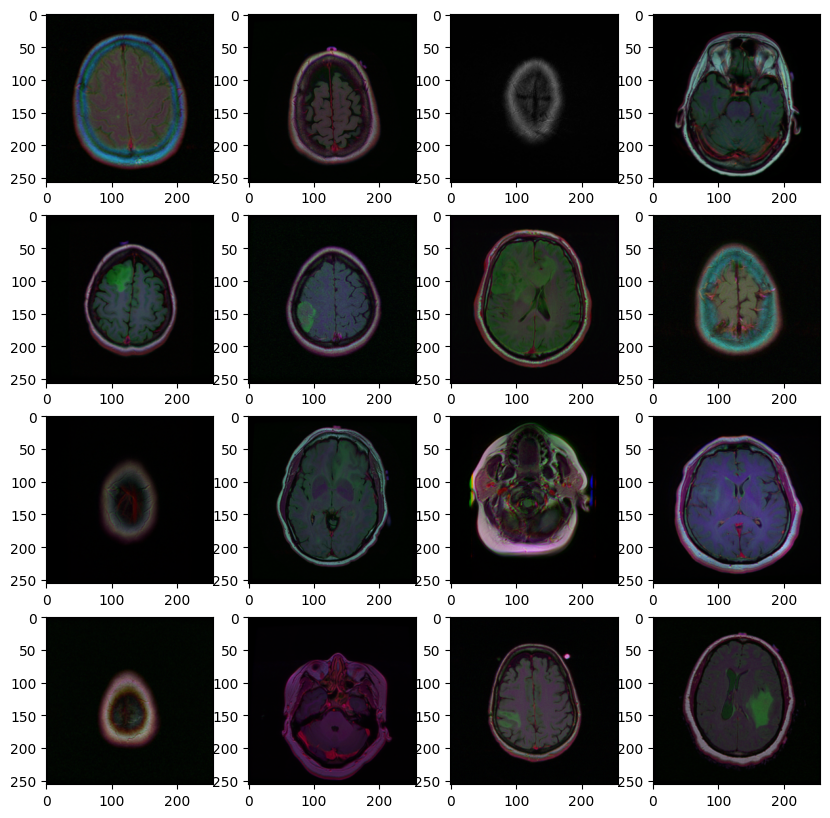

In [4]:
#OBS: uma boa forma de garantir que tudo está correto até o momento é obter um lote de dados e fazer o plot dele
image_batch, mask_batch = next(iter(train_dataloader))
print('Shape: ', image_batch.shape)

fig, axs = plt.subplots(4,4, figsize=(10, 10))

idx = 0
for lin in axs:
    for col in lin:
        tensor = image_batch[idx]
        tensor = torch.permute(tensor, (1, 2, 0))  # organizando as dimensões para o formato (Widh, Height, Channels)
        col.imshow(tensor)
    
        idx+=1

In [5]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import JaccardLoss
from segmentation_models_pytorch.metrics import functional
import torch.nn as nn
import torch.optim as optim

# Veja: https://smp.readthedocs.io/en/latest/
model = smp.UnetPlusPlus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = JaccardLoss(mode='binary')
num_epochs = 20

In [10]:
# Loop de treino (abaixo coloquei um codigo para carregar 
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_iou = 0.0

    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        tp, fp, fn, tn = functional.get_stats(outputs, masks.unsqueeze(dim=1), mode='binary', threshold=0.5)
        train_iou += functional.iou_score(tp, fp, fn, tn).mean()

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_iou = train_iou / len(train_dataloader)

    # Avaliação
    model.eval()
    test_loss = 0.0
    test_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            test_loss += loss.item()
            tp, fp, fn, tn = functional.get_stats(outputs, masks.unsqueeze(dim=1), mode='binary', threshold=0.5)
            test_iou += functional.iou_score(tp, fp, fn, tn).mean()

    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_iou = test_iou / len(test_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} IoU: {avg_train_iou:.4f} | Test Loss: {avg_test_loss:.4f} IoU: {avg_test_iou:.4f}")

Epoch 1/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 1/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 0.9966 IoU: 0.2840 | Test Loss: 0.9964 IoU: 0.4415


Epoch 2/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.9964 IoU: 0.3850 | Test Loss: 0.9963 IoU: 0.4842


Epoch 3/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.9963 IoU: 0.5538 | Test Loss: 0.9963 IoU: 0.6136


Epoch 4/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 4/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.9963 IoU: 0.6804 | Test Loss: 0.9962 IoU: 0.7331


Epoch 5/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 5/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.9962 IoU: 0.5999 | Test Loss: 0.9962 IoU: 0.5860


Epoch 6/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 6/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.9962 IoU: 0.6229 | Test Loss: 0.9962 IoU: 0.5392


Epoch 7/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 7/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.9962 IoU: 0.6861 | Test Loss: 0.9962 IoU: 0.6288


Epoch 8/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 8/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.9962 IoU: 0.6362 | Test Loss: 0.9962 IoU: 0.6325


Epoch 9/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 9/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.9961 IoU: 0.6049 | Test Loss: 0.9962 IoU: 0.7278


Epoch 10/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 10/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.9961 IoU: 0.7159 | Test Loss: 0.9961 IoU: 0.6927


Epoch 11/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 11/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.9961 IoU: 0.7683 | Test Loss: 0.9961 IoU: 0.7186


Epoch 12/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 12/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.9861 IoU: 0.7794 | Test Loss: 0.9962 IoU: 0.7556


Epoch 13/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 13/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.9961 IoU: 0.7510 | Test Loss: 0.9961 IoU: 0.5561


Epoch 14/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 14/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.9961 IoU: 0.5877 | Test Loss: 0.9962 IoU: 0.6208


Epoch 15/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 15/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.9961 IoU: 0.6494 | Test Loss: 0.9961 IoU: 0.5763


Epoch 16/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 16/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.9961 IoU: 0.7202 | Test Loss: 0.9962 IoU: 0.7693


Epoch 17/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 17/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 0.9961 IoU: 0.7934 | Test Loss: 0.9962 IoU: 0.7786


Epoch 18/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 18/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.9961 IoU: 0.7517 | Test Loss: 0.9961 IoU: 0.6145


Epoch 19/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 19/50 [Test]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 0.9961 IoU: 0.7369 | Test Loss: 0.9962 IoU: 0.6968


Epoch 20/50 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
# Salvando os checkpoints do modelo
model.save_pretrained('./model_checkpoints')

Loading weights from local directory
IOU:  tensor(0.0223, device='cuda:0')


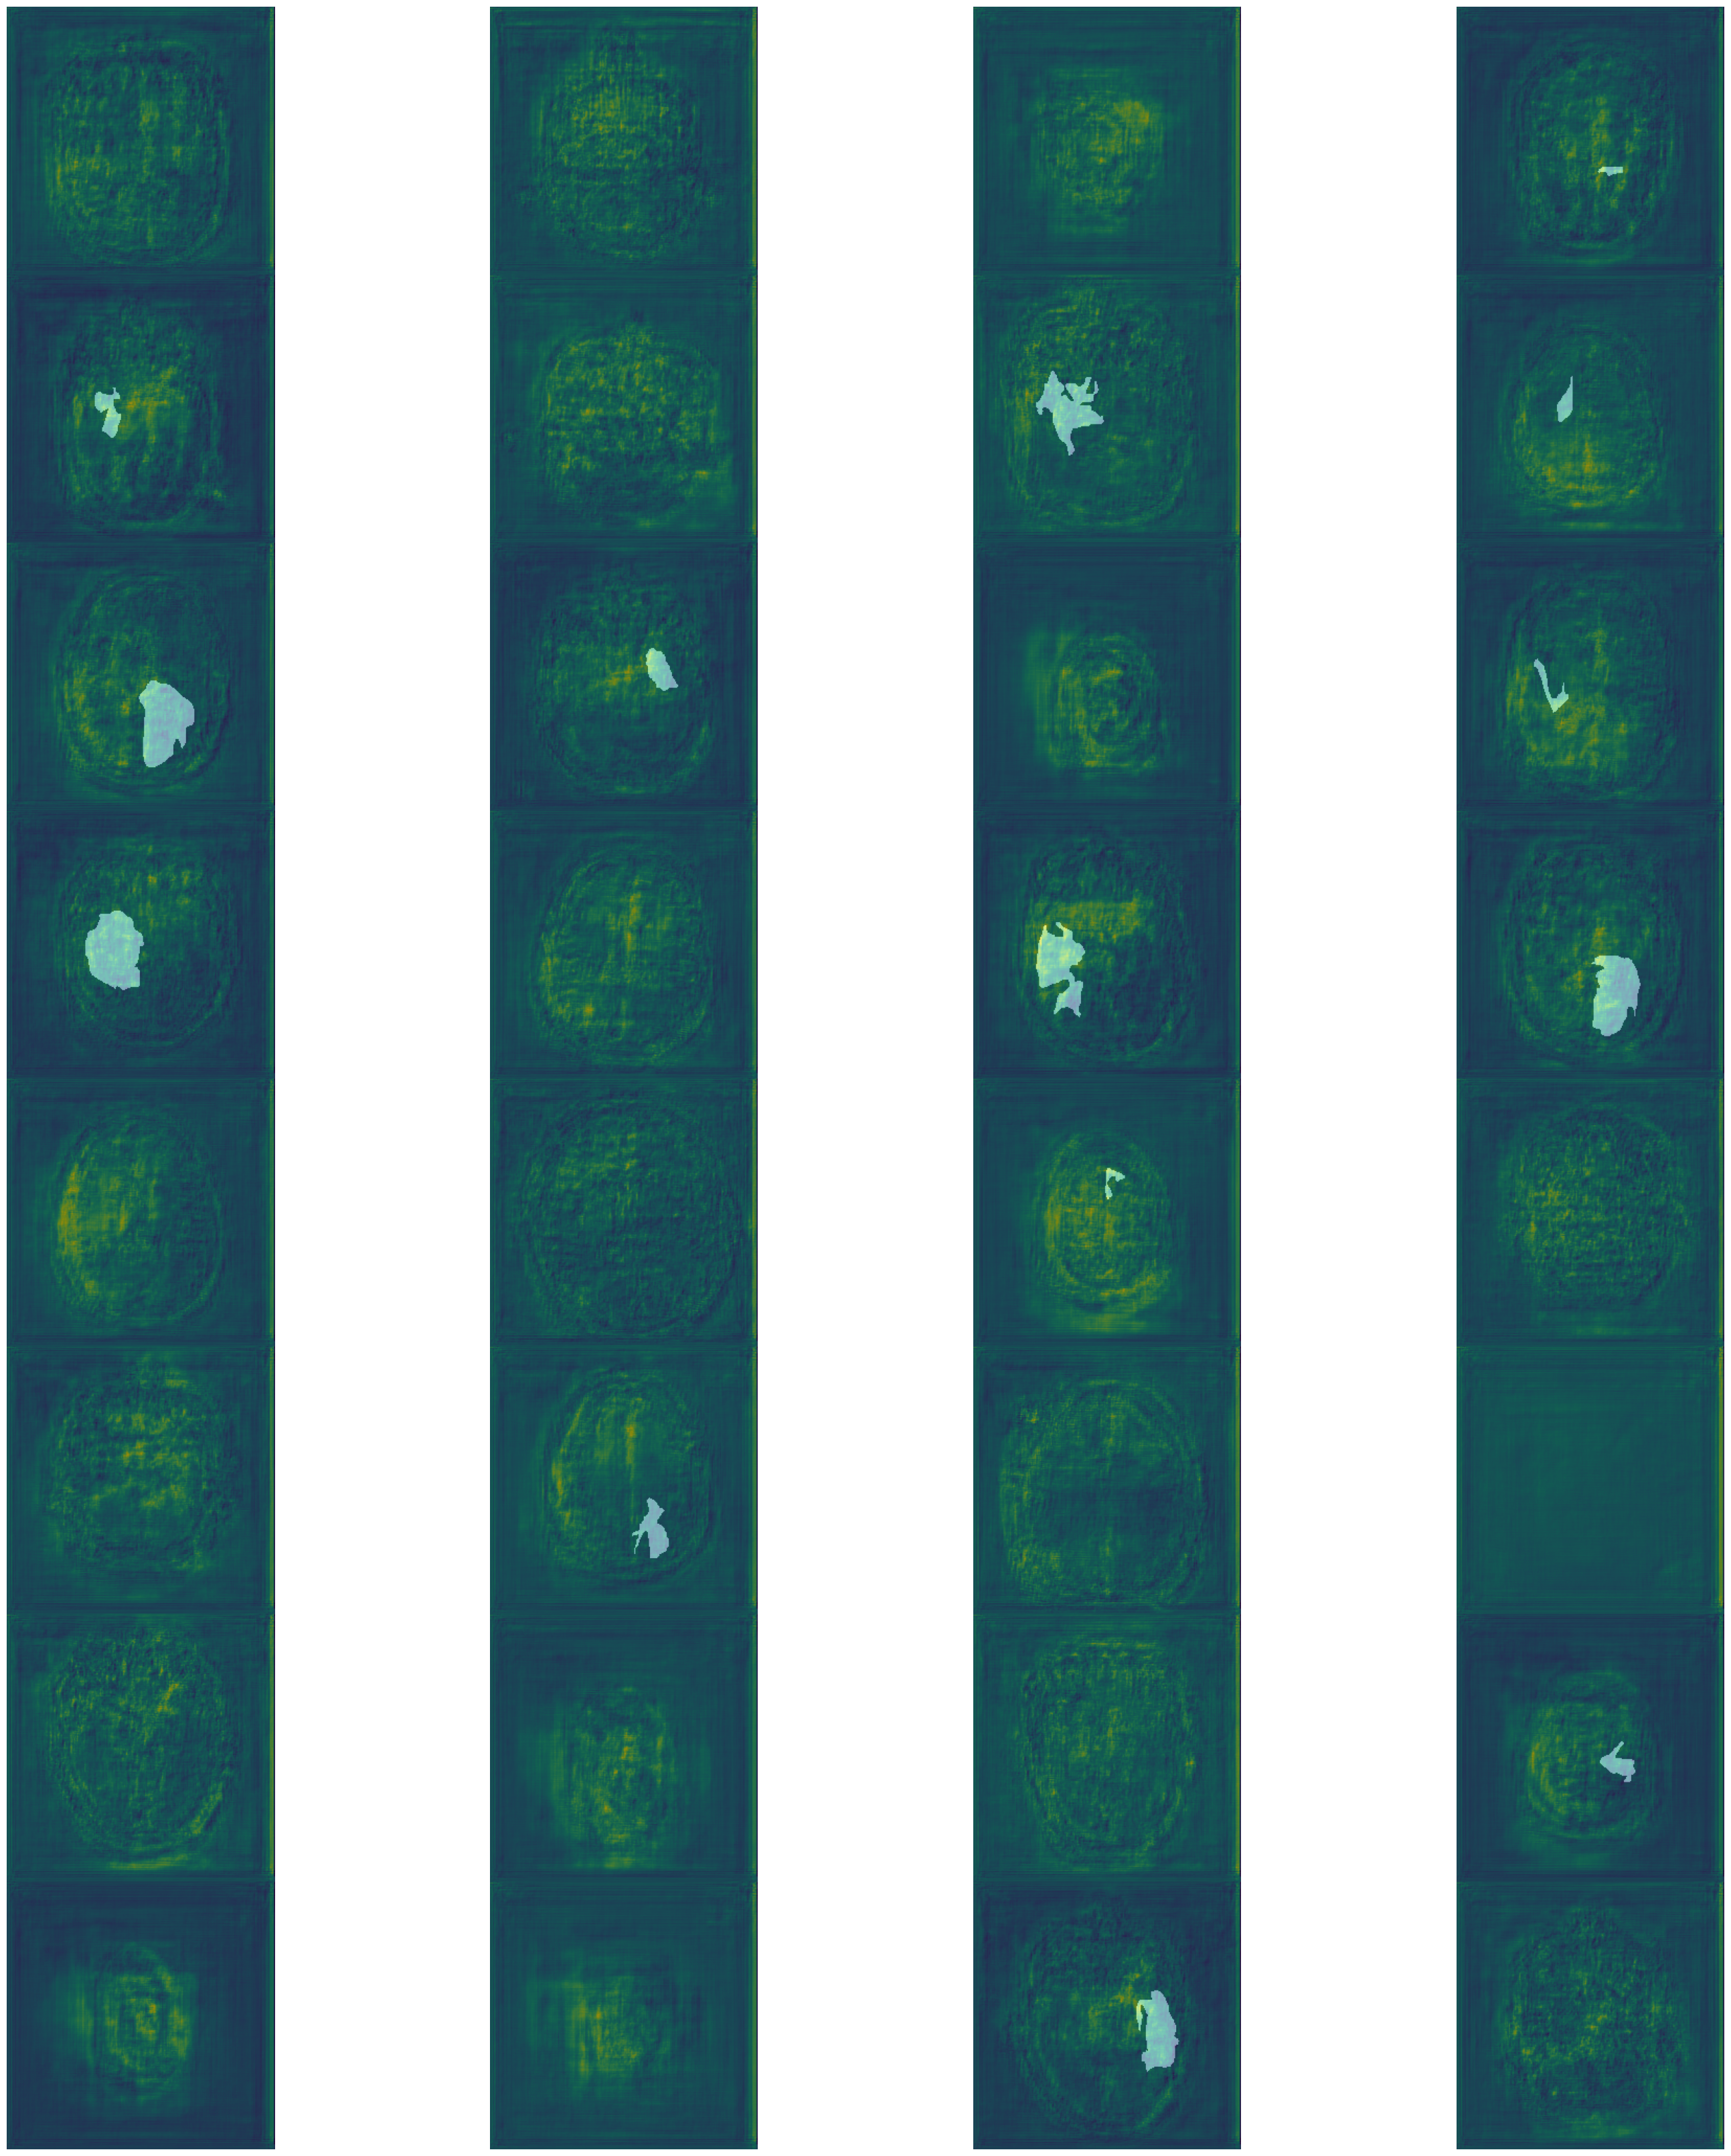

In [34]:
# Carregando o modelo
model = smp.from_pretrained('./model_checkpoints')
model.to(device)

# Análise das predições
image_batch, mask_batch = next(iter(test_dataloader))

model.eval()
with torch.no_grad():
    image_batch = image_batch.to(device)
    mask_batch = mask_batch.to(device)

    outputs = model(image_batch)

    tp, fp, fn, tn = functional.get_stats(outputs, mask_batch.unsqueeze(dim=1), mode='binary', threshold=0.5)
    iou = functional.iou_score(tp, fp, fn, tn).mean()
    print('IOU: ', iou)
    
    fig, axs = plt.subplots(8, 4, figsize=(32,32))
    cont = 0
    for output, mask in zip(outputs, mask_batch):
        axs[cont // 4][cont - 4*(cont // 4)].imshow(torch.permute(output.cpu(), (1, 2, 0)).detach().numpy())
        # Talvez seja mais interessante desenhar os contornos por cima da saida do modelo com a drawContours da OpenCV
        axs[cont // 4][cont - 4*(cont // 4)].imshow(mask.cpu().detach().numpy(), alpha=0.4, cmap='gray')
        axs[cont // 4][cont - 4*(cont // 4)].axis('off')
        cont += 1

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(0)
    plt.tight_layout(pad=0)
    plt.show()

# YOLOv8

In [131]:
!pip install -qU ultralytics

In [33]:
# Carregando o modelo pre-treinado no MS COCO (https://docs.ultralytics.com/pt/datasets/detect/coco/)
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

model.info()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/duque/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.74M/6.74M [00:00<00:00, 26.0MB/s]


YOLOv8n-seg summary: 151 layers, 3,409,968 parameters, 0 gradients, 12.8 GFLOPs


(151, 3409968, 0, 12.772710400000001)

In [138]:
# Convertendo o conjunto de dados de interesse em um formato adequado para YOLO
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
import os


def lgg_mri_segmentation_to_yolo(dataset_root_dir: Path, store_dir: Path, test_size=0.25):
    ''' Converte o dataset apresentado para o formato que a Ultralytics espera.

    Tente ver as etapas chaves e ignorar as especificidades do dataset em questão. O
    mesmo código pode ser melhorado para adaptar um dataset diferente. 
    '''
    mask_paths = list(dataset_root_dir.glob('*/*_mask.tif'))
    image_paths = [(path.parent / path.name.replace('_mask', '')) for path in mask_paths]

    assert len(mask_paths) == len(image_paths)

    # Divisão (treino-teste)
    train_paths, test_paths, train_masks_paths, test_masks_paths = train_test_split(
        image_paths, mask_paths, test_size=test_size, random_state=42
    )

    for sub_dir in ['train', 'val']:
        (store_dir / sub_dir).mkdir(parents=True, exist_ok=True)
        (store_dir / sub_dir).mkdir(parents=True, exist_ok=True)

        if sub_dir == 'train':
            image_paths = train_paths
            mask_paths = train_masks_paths
        else:
            image_paths = test_paths
            mask_paths = test_masks_paths


        for mask_path, image_path in tqdm(zip(mask_paths, image_paths), total=len(mask_paths), desc=sub_dir+' dir |'):
            image = cv2.imread(str(image_path))
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

            # conversão tif-> png (aqui pode ocorrer qualquer conversão de formato de imagem)
            png_path = store_dir / sub_dir / image_path.with_suffix('.png').name
            cv2.imwrite(str(png_path), image)

            # convertendo imagem binária para coordenadas
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


            contour_image = np.zeros_like(mask)
            bounding_rect_image = mask.copy()
            yolo_bbox_image = mask.copy()

            all_coords = []

            # Veja mais informações sobre o formato esperado: https://docs.ultralytics.com/pt/datasets/segment/#ultralytics-yolo-format
            for contour in contours:
                class_label = 0  # nome da classe (pode colocar apenas um número, e indicar o nome da classe no data.yaml)
                
                for coordinate_pair_list in contour:
                        for coordinate_pair in coordinate_pair_list:
                            x, y = coordinate_pair
                            x_norm = x / image.shape[1]
                            y_norm = y / image.shape[0]
                            
                            all_coords.append(str(x_norm))
                            all_coords.append(str(y_norm))


            # escrevendo no arquivo .txt
            annotation_file_path = str(store_dir / sub_dir /image_path.with_suffix('.txt').name)
            with open(annotation_file_path, "w") as file:
                line = f"{class_label} " + " ".join(all_coords)  # muita atenção no momento de construção da linha (https://docs.ultralytics.com/pt/datasets/segment/#ultralytics-yolo-format)
                
                if len(all_coords) == 0:
                    line = ""
                    
                file.write(line)

In [139]:
lgg_mri_segmentation_to_yolo(dataset_root_dir=Path('./kaggle_3m'), store_dir=Path('./kaggle_3m_yolo'))

train dir |:   0%|          | 0/2946 [00:00<?, ?it/s]

val dir |:   0%|          | 0/983 [00:00<?, ?it/s]

In [141]:
# Treinamento da YOLO
results = model.train(data="dataset.yaml", epochs=10, imgsz=256)

New https://pypi.org/project/ultralytics/8.3.149 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.148 🚀 Python-3.12.3 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12029MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train72, nbs=64, nms=False, opset=None, optimize=

train: Scanning /home/duque/Área de Trabalho/Monitoria 2025/yolo_unetpp_seg/kaggle_3m_yolo/train.cache... 2946 images, 1914 backgrounds, 0 corrupt: 100%|██████████| 29


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1201.6±698.6 MB/s, size: 76.5 KB)


val: Scanning /home/duque/Área de Trabalho/Monitoria 2025/yolo_unetpp_seg/kaggle_3m_yolo/val.cache... 983 images, 642 backgrounds, 0 corrupt: 100%|██████████| 983/983 


Plotting labels to /home/duque/Área de Trabalho/Monitoria 2025/yolo_unetpp_seg/runs/segment/train72/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to /home/duque/Área de Trabalho/Monitoria 2025/yolo_unetpp_seg/runs/segment/train72
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.15G      1.271      2.235     0.8563      1.108          1        256: 100%|██████████| 185/185 [00:07<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:

                   all        983        341      0.873      0.783      0.862      0.503      0.879      0.789      0.855      0.462

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       2/10      1.16G      1.339      2.299     0.9332      1.134          2        256: 100%|██████████| 185/185 [00:07<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:

                   all        983        341      0.865      0.798      0.858      0.529      0.859      0.785      0.844      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.16G       1.35      2.283     0.9463       1.15          0        256: 100%|██████████| 185/185 [00:07<00:00, 25.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:


                   all        983        341       0.86      0.792      0.859      0.517      0.884      0.771      0.845      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.16G      1.351      2.294      1.008      1.156          0        256: 100%|██████████| 185/185 [00:07<00:00, 25.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:


                   all        983        341      0.874      0.774      0.861      0.526      0.888      0.767      0.852      0.482

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.16G      1.311      2.218      0.911      1.123          0        256: 100%|██████████| 185/185 [00:07<00:00, 26.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:


                   all        983        341      0.879      0.766      0.855      0.521      0.892      0.752      0.835      0.464

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.16G      1.244      2.147     0.8795      1.101          0        256: 100%|██████████| 185/185 [00:07<00:00, 25.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:

                   all        983        341      0.901      0.806      0.884      0.556      0.903      0.809      0.885        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.16G      1.236      2.098     0.8102      1.089          1        256: 100%|██████████| 185/185 [00:07<00:00, 25.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:

                   all        983        341      0.906      0.824      0.903      0.583      0.906      0.824      0.889      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.16G       1.21      2.061     0.7825      1.081          1        256: 100%|██████████| 185/185 [00:07<00:00, 25.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:

                   all        983        341      0.897      0.817      0.896      0.567      0.895      0.804      0.873      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.16G      1.168      2.031     0.7427      1.069          2        256: 100%|██████████| 185/185 [00:07<00:00, 25.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:

                   all        983        341      0.931      0.797      0.895      0.571      0.928      0.794      0.884      0.511

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



      10/10      1.16G      1.111      1.958     0.7036      1.048          0        256: 100%|██████████| 185/185 [00:07<00:00, 25.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:

                   all        983        341       0.92      0.839      0.916      0.599      0.937      0.822      0.906      0.527



10 epochs completed in 0.025 hours.
Optimizer stripped from /home/duque/Área de Trabalho/Monitoria 2025/yolo_unetpp_seg/runs/segment/train72/weights/last.pt, 6.8MB
Optimizer stripped from /home/duque/Área de Trabalho/Monitoria 2025/yolo_unetpp_seg/runs/segment/train72/weights/best.pt, 6.8MB

Validating /home/duque/Área de Trabalho/Monitoria 2025/yolo_unetpp_seg/runs/segment/train72/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.12.3 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12029MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:


                   all        983        341       0.92      0.839      0.916      0.599      0.937      0.823      0.905      0.527
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/duque/Área de Trabalho/Monitoria 2025/yolo_unetpp_seg/runs/segment/train72
